# F1 Lap Time Prediction

<b>Objective</b>
- The purpose of this notebook is to explore F1 set up data used to predict lap time and find the optimal set up for a given track and weather condition.

<b>Success Criteria</b>
- A successful model predicting laptime for a given set up.
- The incorporation of tyre degredation.
- An optimal setup for a given track and weather condition.

## Imports

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

## Data Gathering
As there is no available data we will create a synthetic dataset

In [4]:
def generate_lap_time_data(
    num_samples=50000,
    random_seed=42
) -> pd.DataFrame:
    np.random.seed(random_seed)
    # Generate random data
    df = pd.DataFrame({
        'track': np.random.choice(['Track_A', 'Track_B', 'Track_C', 'Track_D', 'Track_E'], size=num_samples),
        'weather': np.random.choice(['sunny', 'rainy', 'cloudy'], num_samples, p=[0.8, 0.05, 0.15]),
        'tyre_age': np.random.randint(0, 100, size=num_samples),
        'front_wing_angle': np.random.uniform(0, 10, size=num_samples),
        'rear_wing_angle': np.random.uniform(0, 10, size=num_samples),
        'ride_height_front': np.random.uniform(30, 50, size=num_samples),
        'ride_height_rear': np.random.uniform(50, 70, size=num_samples),
        'camber_angle': np.random.uniform(-3.5, -1.0, size=num_samples),
        'toe_angle': np.random.uniform(0.0, 1.5, size=num_samples),
        'brake_bias': np.random.uniform(50, 70, size=num_samples),
        'lap': np.random.randint(1, 70, size=num_samples),
        'fuel_load': np.random.uniform(10, 100, size=num_samples),
        'track_temperature': np.random.uniform(15, 50, size=num_samples),
        'ambient_temperature': np.random.uniform(10, 35, size=num_samples)
    })

    # Generate lap time & Tyre Deg data
    df['lap_time'] = (80 - 0.5 * df['front_wing_angle'] - 0.3 * df['rear_wing_angle']
                  + 0.02 * df['tyre_age'] + 0.04 * df['fuel_load'] + 0.1 * (df['track_temperature'] - 25)
                  + np.random.normal(0, 0.5, size=num_samples))
    df['tyre_degradation'] = (0.2 * df['lap'] + 0.5 * (df['track_temperature'] - 20)
                            + 0.1 * df['front_wing_angle'] + 0.1 * df['rear_wing_angle']
                            + np.random.normal(0, 0.2, size=num_samples))
    df['lap_time'] = df['lap_time'].clip(lower=50)
    df['tyre_degradation'] = df['tyre_degradation'].clip(lower=0)

    return df

In [5]:
setup_dataset = generate_lap_time_data()

## EDA
Exploring the dataset to check for any null values, correlations with other features and the target etc.

In [6]:
print("\nSummary Statistics:")
display(setup_dataset.describe())


Summary Statistics:


tyre_age  front_wing_angle  rear_wing_angle  ride_height_front   
count  50000.000000      50000.000000     50000.000000       50000.000000  \
mean      49.590440          5.018587         5.002844          40.032672   
std       28.853016          2.884827         2.892228           5.770449   
min        0.000000          0.000066         0.000048          30.000046   
25%       24.000000          2.518757         2.491562          35.060966   
50%       50.000000          5.024224         5.007147          40.014151   
75%       75.000000          7.506864         7.500063          45.012368   
max       99.000000          9.999894         9.999830          49.998595   

       ride_height_rear  camber_angle     toe_angle    brake_bias   
count      50000.000000  50000.000000  50000.000000  50000.000000  \
mean          59.976866     -2.250281      0.749782     60.016542   
std            5.768124      0.721112      0.433657      5.761875   
min           50.000045     -3.499954      0.000060     50.000430   
25%           54.965615     -2.875643      0.376660     55.015664   
50%           59.972999     -2.250908      0.750766     60.069072   
75%           64.982469     -1.627031      1.125712     64.973891   
max           69.998544     -1.000013      1.499976     69.999739   

                lap     fuel_load  track_temperature  ambient_temperature   
count  50000.000000  50000.000000       50000.000000         50000.000000  \
mean      35.024480     55.128638          32.408200            22.515055   
std       19.861406     25.921492          10.108501             7.219230   
min        1.000000     10.000634          15.000184            10.002335   
25%       18.000000     32.893304          23.622694            16.298422   
50%       35.000000     54.947722          32.398668            22.486286   
75%       52.000000     77.484246          41.152665            28.768334   
max       69.000000     99.996884          49.999630            34.999873   

           lap_time  tyre_degradation  
count  50000.000000      50000.000000  
mean      79.928838         14.213030  
std        2.345841          6.447113  
min       71.755308          0.000000  
25%       78.304328          9.537936  
50%       79.922428         14.212115  
75%       81.563492         18.868864  
max       88.636106         30.631598

In [7]:
print("\nMissing Values in Each Column:")
display(setup_dataset.isnull().sum())


Missing Values in Each Column:


track                  0
weather                0
tyre_age               0
front_wing_angle       0
rear_wing_angle        0
ride_height_front      0
ride_height_rear       0
camber_angle           0
toe_angle              0
brake_bias             0
lap                    0
fuel_load              0
track_temperature      0
ambient_temperature    0
lap_time               0
tyre_degradation       0
dtype: int64

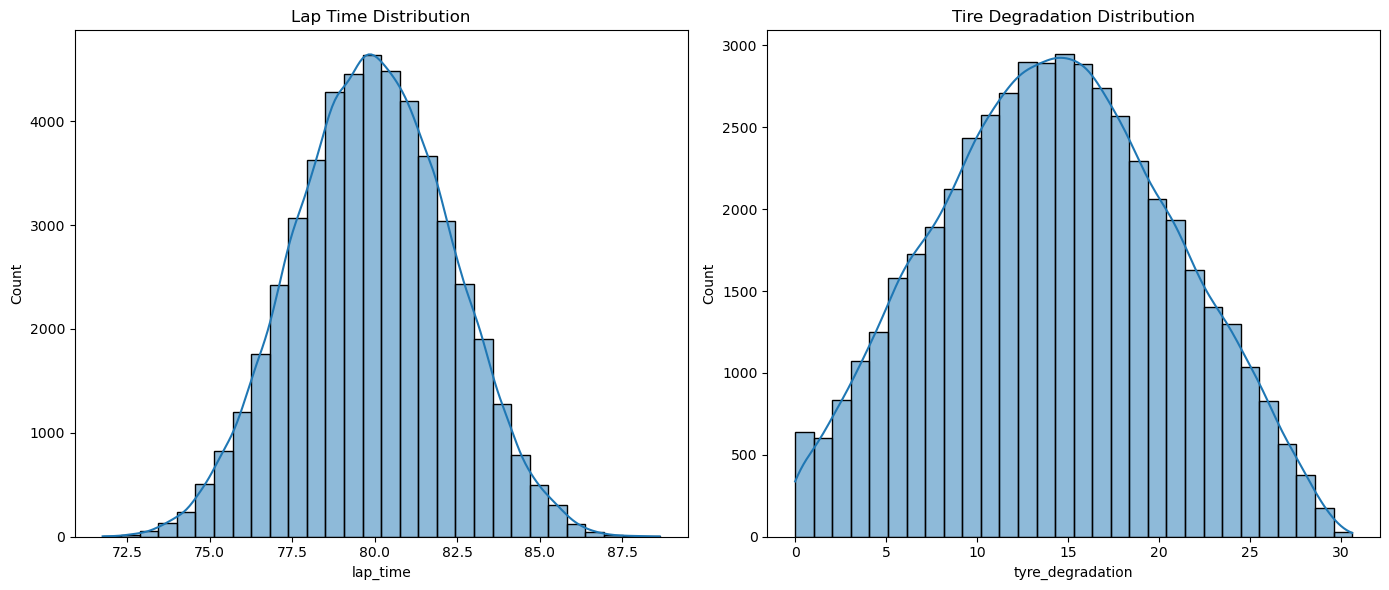

In [12]:
# Step 2: Distribution of Target Variables (Lap Time and Tire Degradation)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(setup_dataset['lap_time'], kde=True, bins=30)
plt.title("Lap Time Distribution")

plt.subplot(1, 2, 2)
sns.histplot(setup_dataset['tyre_degradation'], kde=True, bins=30)
plt.title("Tire Degradation Distribution")

plt.tight_layout()
plt.show()

In [13]:
# Step 3: Analyzing Feature Relationships with Target Variables
# Numerical feature vs Lap Time
numerical_features = ['tyre_age', 'front_wing_angle', 'rear_wing_angle', 
                      'ride_height_front', 'ride_height_rear', 'camber_angle', 
                      'toe_angle', 'brake_bias', 'lap', 'fuel_load', 
                      'track_temperature', 'ambient_temperature']

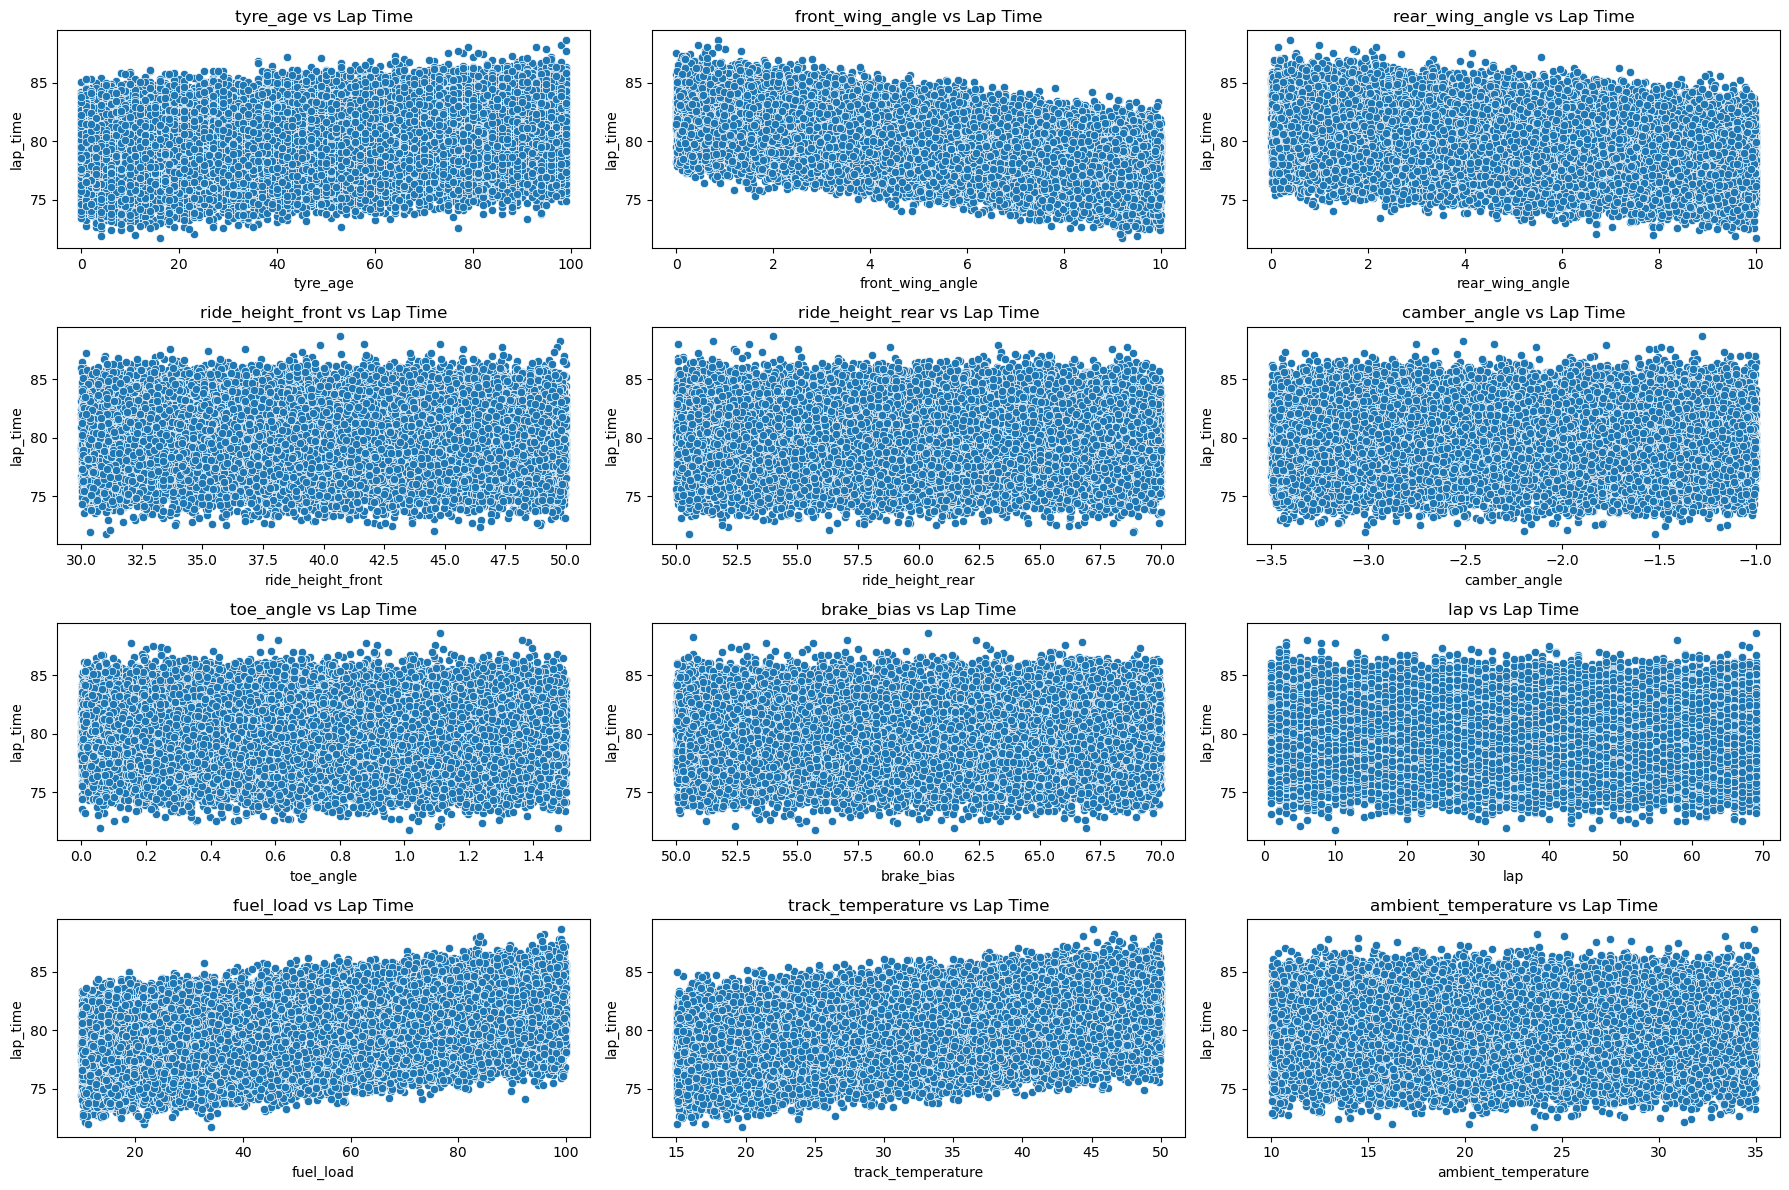

In [14]:
plt.figure(figsize=(18, 12))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 3, i)
    sns.scatterplot(x=setup_dataset[feature], y=setup_dataset['lap_time'])
    plt.title(f"{feature} vs Lap Time")
plt.tight_layout()
plt.show()

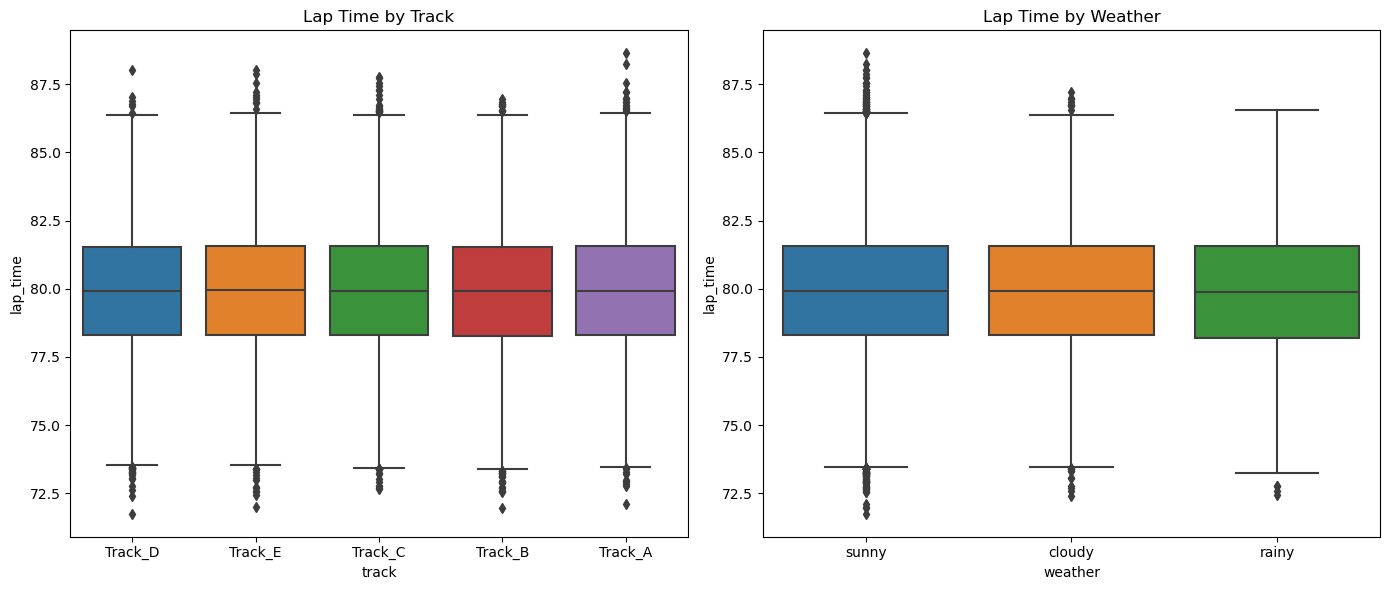

In [15]:
# Analyzing Categorical Features (Track and Weather) vs Lap Time
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=setup_dataset, x='track', y='lap_time')
plt.title("Lap Time by Track")

plt.subplot(1, 2, 2)
sns.boxplot(data=setup_dataset, x='weather', y='lap_time')
plt.title("Lap Time by Weather")

plt.tight_layout()
plt.show()

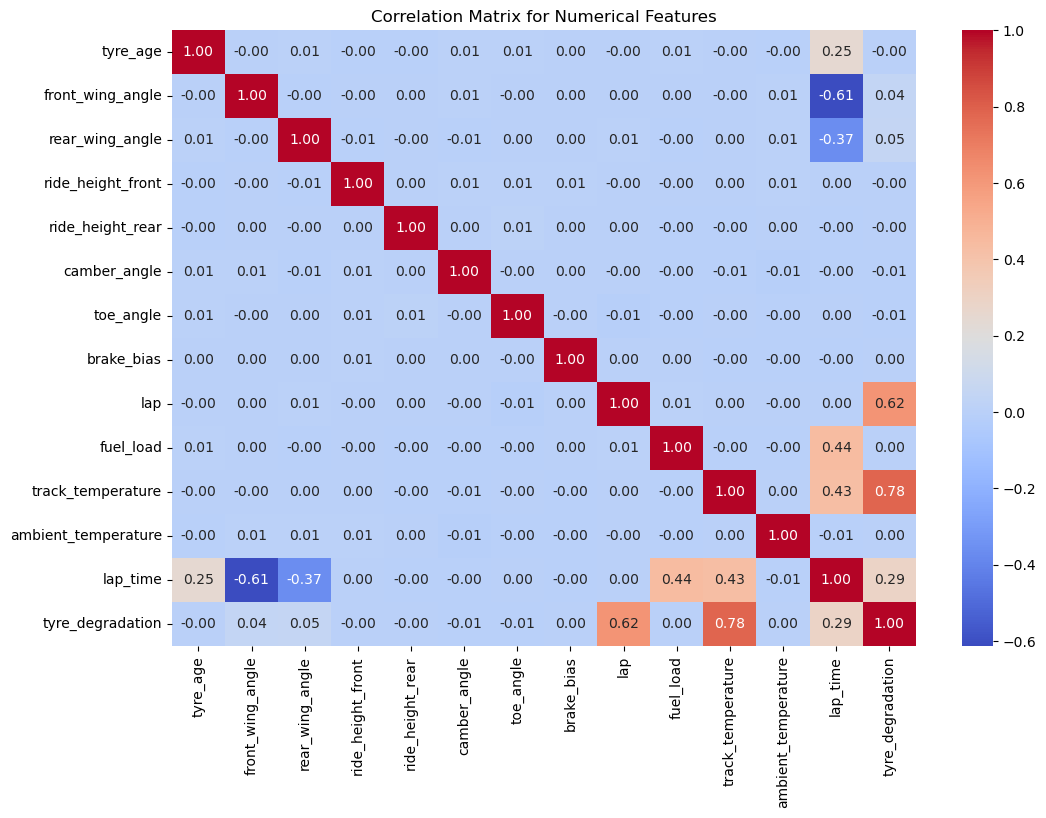

In [20]:
# Step 4: Correlation Analysis
# Correlation Matrix and Heatmap for Numerical Features
corr_matrix = setup_dataset[numerical_features+['lap_time','tyre_degradation']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Numerical Features")
plt.show()

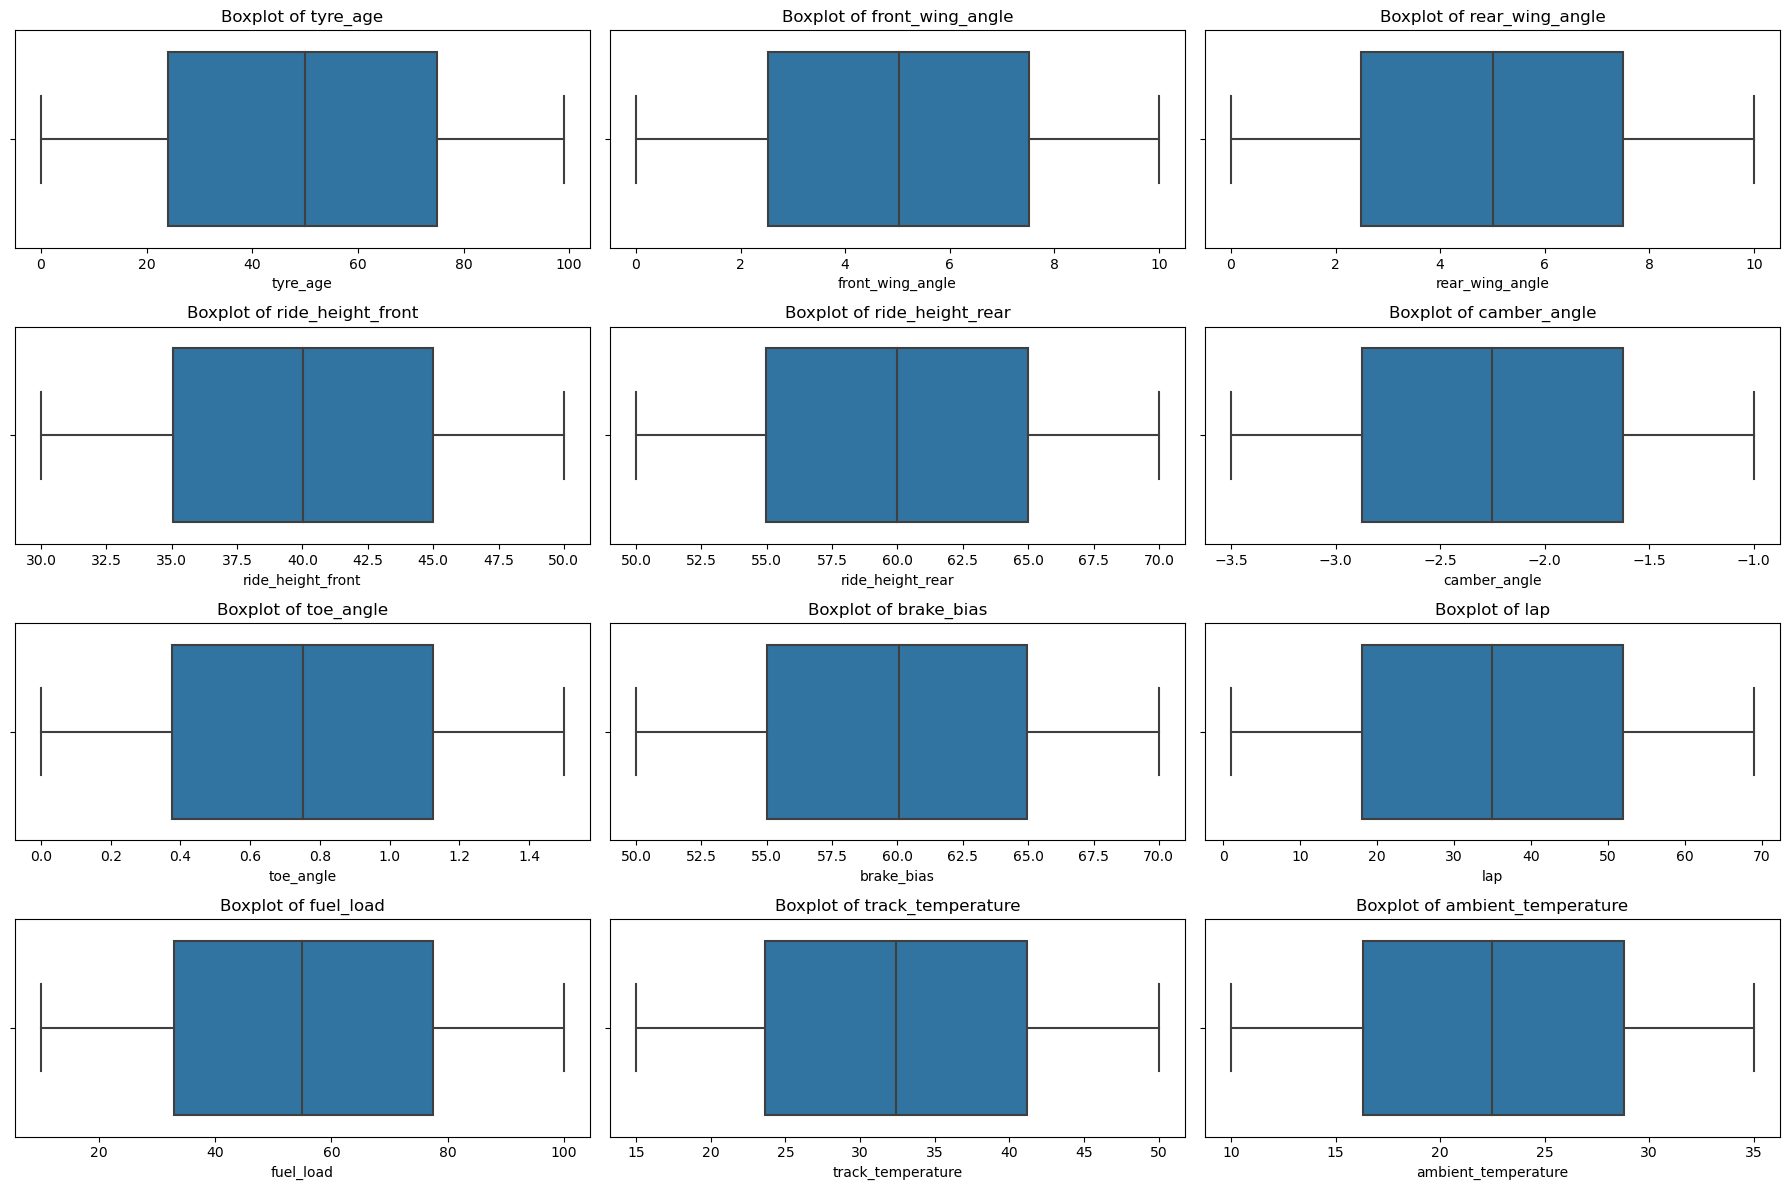

In [21]:
# Step 5: Identify Outliers using Boxplots for Key Features
plt.figure(figsize=(18, 12))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=setup_dataset[feature])
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

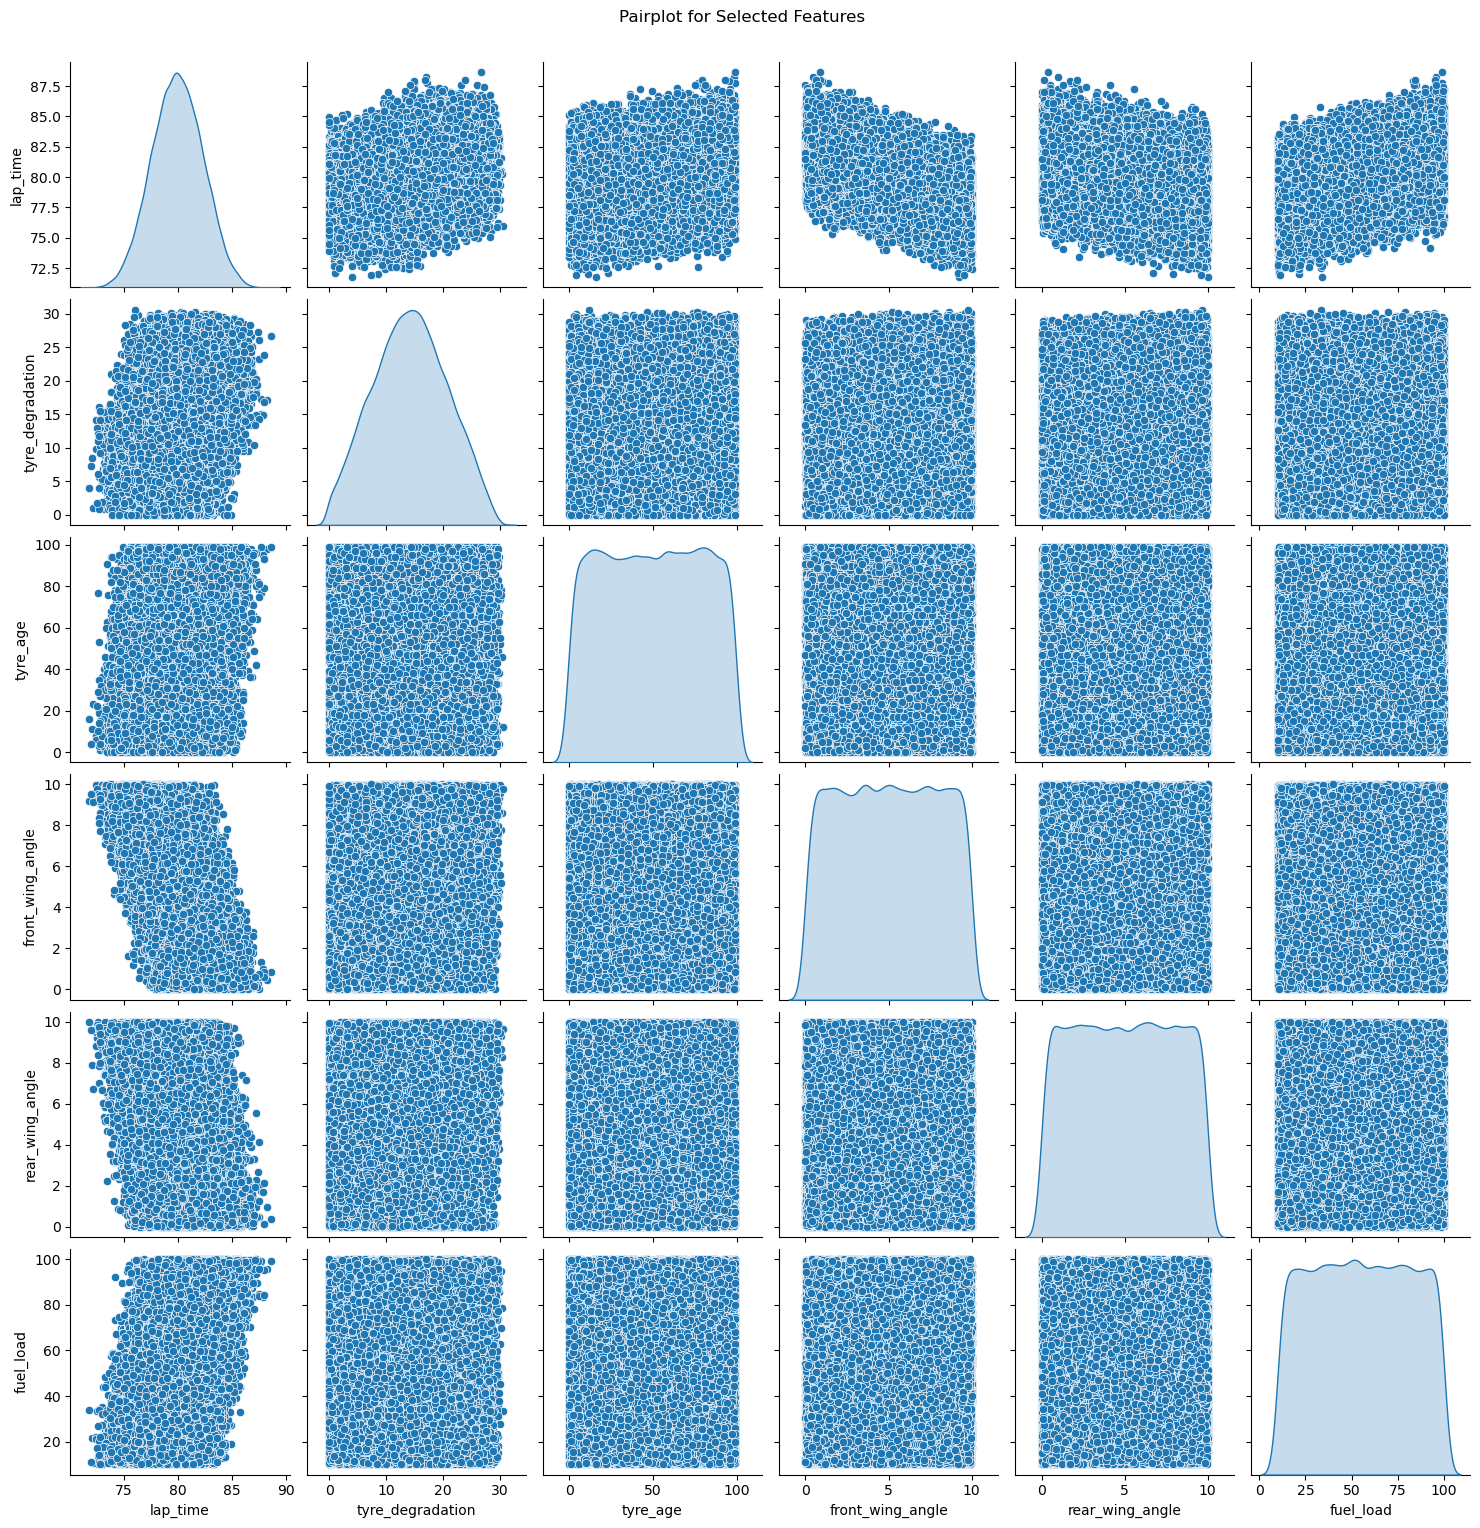

In [22]:
# Step 6: Pairplot for Selected Features to Identify Relationships
selected_features = ['lap_time', 'tyre_degradation', 'tyre_age', 'front_wing_angle', 'rear_wing_angle', 'fuel_load']
sns.pairplot(setup_dataset[selected_features], diag_kind='kde')
plt.suptitle("Pairplot for Selected Features", y=1.02)
plt.show()

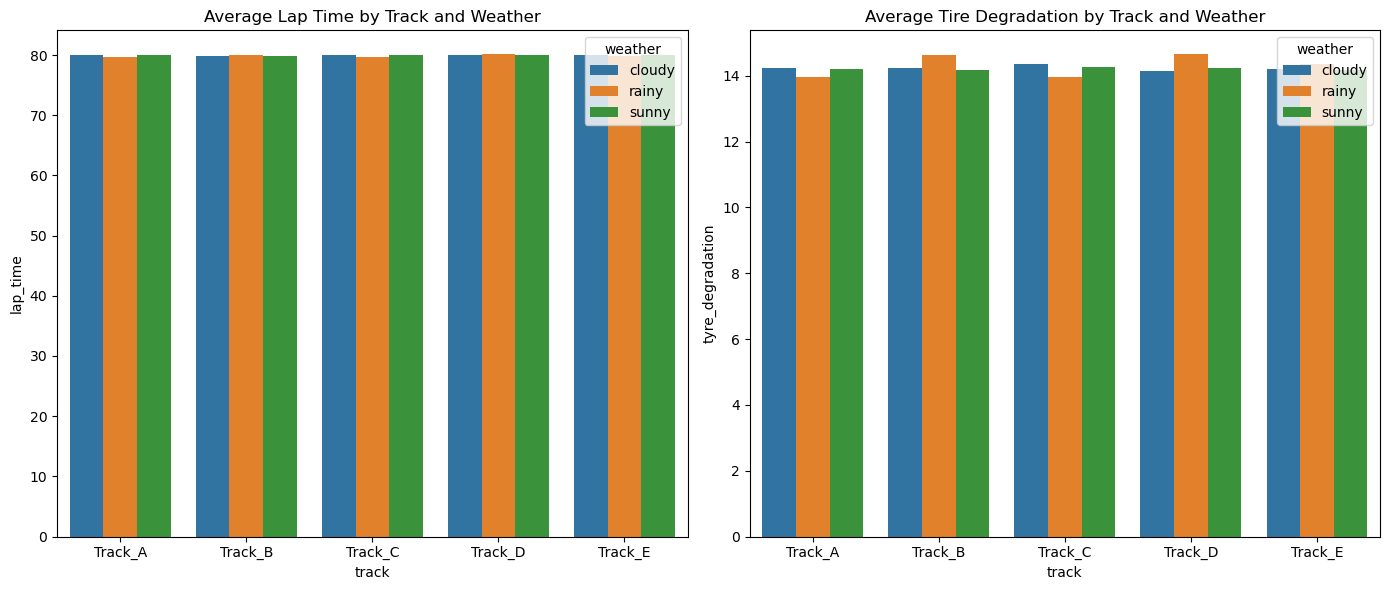

In [24]:
# Step 7: Categorical Variable Analysis with Target (Lap Time)
# Analyzing the average lap time and tire degradation per track and weather
track_weather_group = setup_dataset.groupby(['track', 'weather'])[['lap_time', 'tyre_degradation']].mean().reset_index()
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=track_weather_group, x='track', y='lap_time', hue='weather')
plt.title("Average Lap Time by Track and Weather")

plt.subplot(1, 2, 2)
sns.barplot(data=track_weather_group, x='track', y='tyre_degradation', hue='weather')
plt.title("Average Tire Degradation by Track and Weather")

plt.tight_layout()
plt.show()

<b> Inbalanced target variables SMOTE </b>
```python
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Example dataset (assuming 'target' is the binary target variable)
# df = pd.read_csv('your_data.csv')  # Uncomment if loading from a file
X = df.drop('target', axis=1)
y = df['target']

# Step 1: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check class distribution before SMOTE
print("Class distribution before SMOTE:", Counter(y_train))

# Step 2: Apply SMOTE to the training set only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:", Counter(y_train_smote))

# Your X_train_smote and y_train_smote are now balanced and ready for model training
```

<b> Imputation Strategy </b>
In the case where we have null values and need to impute we can full based on the groupby strategy.
```python
# Display initial missing values count for reference
print("Missing values before imputation:")
print(df.isnull().sum())

# Define the columns you want to impute based on the 'track' group
columns_to_impute = ['tyre_age', 'front_wing_angle', 'rear_wing_angle']

# Impute missing values by the mean of each group (track)
for col in columns_to_impute:
    df[col] = df.groupby('track')[col].transform(lambda x: x.fillna(x.mean()))

# Display missing values count after imputation
print("\nMissing values after imputation:")
print(df.isnull().sum())
```

<b> Handling Extreme Values </b>
In the case where we have data anomalies we can remove the values based in the interquartile range or imput the values for them.
```python
QR for a specific column
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Apply the function to the 'lap_time' column
df = remove_outliers_iqr(df, 'lap_time')

# Replace values outside a reasonable range with the group mean
for col in ['lap_time', 'tyre_degradation']:
    df[col] = df.groupby('track')[col].transform(lambda x: np.where(x > x.mean() + 3 * x.std(), x.mean(), x))

# Cap lap times to a maximum value, e.g., based on 99th percentile
cap_value = df['lap_time'].quantile(0.99)
df['lap_time'] = df['lap_time'].clip(upper=cap_value)
```

<b> Handling Correlated Features </b>
In the Scenario where we have correlated features but we with to keep them both we can use decomposition
```python
# Import necessary libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming df is your DataFrame with correlated features
# Let's say 'front_wing_angle', 'rear_wing_angle', and 'ride_height_front' are correlated features

# Step 1: Select correlated features
correlated_features = ['front_wing_angle', 'rear_wing_angle', 'ride_height_front']

# Step 2: Standardize the selected features (PCA requires standardized data)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[correlated_features])

# Step 3: Apply PCA
pca = PCA(n_components=1)  # Setting n_components=1 to reduce to a single feature
principal_component = pca.fit_transform(scaled_features)

# Step 4: Add the principal component as a new feature in the dataset
df['pca_feature'] = principal_component

# Optional: Drop the original correlated features if not needed
df = df.drop(columns=correlated_features)

# Display explained variance of the principal component
print("Explained variance by the principal component:", pca.explained_variance_ratio_[0])
```

## Feature Tranformation/Engineering

In [25]:
# Step 2: Define Features and Targets
X = setup_dataset.drop(['lap_time', 'tyre_degradation'], axis=1)
y = setup_dataset[['lap_time', 'tyre_degradation']]

In [26]:
# Step 3: Split Data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [27]:
# Step 4: Preprocessing
categorical_features = ['track', 'weather']
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.difference(categorical_features)

In [28]:
# Must fit on train to avoid data leakage
# In the case where the test dataset has a larger value and we have strict boundaries we must just clip the values
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

<b> Transformation Strategies </b>
1. MinMaxScaler -> Scales features to a specific range, typically between 0 and 1.
    - When to Use: Useful when you want to maintain the original data distribution and are working with models sensitive to the scale of the features (e.g., neural networks).
        ```python
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(df)
        ```
2. MaxAbsScaler -> Scales each feature by its maximum absolute value, resulting in a range between -1 and 1.
    - When to Use: Useful for data that is already centered and when you have sparse data that you don’t want to modify extensively.
        ```python
        from sklearn.preprocessing import MaxAbsScaler
        scaler = MaxAbsScaler()
        scaled_data = scaler.fit_transform(df)
        ```
3. RobustScaler -> Uses the median and the interquartile range (IQR) to scale features, making it less sensitive to outliers.
    - Ideal for data with many outliers, as it’s robust to extreme values.
        ```python
        from sklearn.preprocessing import RobustScaler
        scaler = RobustScaler()
        scaled_data = scaler.fit_transform(df)
        ```
4. Power Transformer -> Applies a power transformation to make data more Gaussian-like, reducing skewness and stabilizing variance.
    - Yeo-Johnson: Works on both positive and negative values.
    - Box-Cox: Works only on positive values.
    - When to Use: Useful for highly skewed data, often improving linear model performance.
        ```python
        from sklearn.preprocessing import PowerTransformer
        pt = PowerTransformer(method='yeo-johnson')  # 'box-cox' if data is positive only
        transformed_data = pt.fit_transform(df)
        ```
5. Quantile Transformer -> Maps data to a uniform or normal distribution by transforming the feature values based on quantiles.
    - When to Use: Effective when you need to normalize or standardize highly skewed features.
        ```python
        from sklearn.preprocessing import QuantileTransformer
        qt = QuantileTransformer(output_distribution='normal')  # 'uniform' also available
        transformed_data = qt.fit_transform(df)
        ```
6. Log Transformation -> Applies a logarithmic transformation to compress the range of data, particularly helpful with data that has large positive skew.
    - When to Use: Ideal for data with many large values and positive skew (e.g., financial data). Note: Only applicable if all values are positive.
        ```python
        import numpy as np
        log_transformed_data = np.log1p(df)  # np.log1p adds 1 to handle 0 values
        ```

1. <b>Handling Features with Outliers</b>: Since setup data may include outliers (e.g., extremes in tire age or ride height due to wear or specific conditions), RobustScaler could be a good choice, as it scales based on the median and interquartile range, making it more resilient to extreme values.
2. <b>MinMaxScaler for Neural Networks and Tree-Based Models</b>: If you’re using neural networks or tree-based models, MinMaxScaler (scaling to a 0-1 range) is often beneficial. Neural networks perform better with normalized data, while tree-based models (like CatBoost) are generally insensitive to scaling but can still benefit from uniform ranges for feature importance.
3. <b>StandardScaler for General Linear Models**</b>: If you’re using a linear regression or models where the magnitude of coefficients is important, StandardScaler (mean=0, standard deviation=1) is a good option to ensure consistent feature contributions.
4. <b>Power Transformer or Quantile Transformer for Skewed Data</b>: For highly skewed data (e.g., fuel load or camber angle), PowerTransformer or QuantileTransformer can help normalize the distribution to approximate a Gaussian shape, potentially improving model stability and predictive power.

In [29]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)])

## Modelling

In [30]:
# Step 5: Define Models (Gradient Boosting and CatBoost)
gb_model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
cb_model = MultiOutputRegressor(CatBoostRegressor(silent=True, random_state=42))

In [31]:
# Step 6: Model and Pipeline
pipelines = {
    'Gradient Boosting': Pipeline(steps=[('preprocessor', preprocessor), ('model', gb_model)]),
    'CatBoost': Pipeline(steps=[('preprocessor', preprocessor), ('model', cb_model)])
}

In [32]:
# Step 7: Define Hyperparameters for Grid Search
param_grid = {
    'Gradient Boosting': {
        'model__estimator__n_estimators': [50, 100],
        'model__estimator__learning_rate': [0.01, 0.1],
        'model__estimator__max_depth': [3, 5]
    },
    'CatBoost': {
        'model__estimator__iterations': [50, 100],
        'model__estimator__learning_rate': [0.01, 0.1],
        'model__estimator__depth': [3, 5]
    }
}

## Evaluation

In [33]:
# Step 8: Grid Search and Model Evaluation
best_models = {}
for model_name, pipeline in pipelines.items():
    print(f"\nTraining {model_name} model with Grid Search...")
    grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=3, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train, y_train)
    
    # Store best model
    best_models[model_name] = grid_search.best_estimator_
    
    # Evaluate on Validation Set
    y_val_pred = grid_search.predict(X_val)
    lap_time_mae = mean_absolute_error(y_val['lap_time'], y_val_pred[:, 0])
    tyre_deg_mae = mean_absolute_error(y_val['tyre_degradation'], y_val_pred[:, 1])
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Validation MAE (Lap Time): {lap_time_mae}")
    print(f"Validation MAE (Tyre Degradation): {tyre_deg_mae}")


Training Gradient Boosting model with Grid Search...
Best parameters for Gradient Boosting: {'model__estimator__learning_rate': 0.1, 'model__estimator__max_depth': 5, 'model__estimator__n_estimators': 100}
Validation MAE (Lap Time): 0.41569187851647316
Validation MAE (Tyre Degradation): 0.18786461094279314

Training CatBoost model with Grid Search...
Best parameters for CatBoost: {'model__estimator__depth': 5, 'model__estimator__iterations': 100, 'model__estimator__learning_rate': 0.1}
Validation MAE (Lap Time): 0.40470650471324515
Validation MAE (Tyre Degradation): 0.1966463729707814


In [40]:
# Evaluating our best model on the test set
final_model = best_models['CatBoost']
y_test_pred = final_model.predict(X_test)

# Calculate RMSE and MAE on the original scale since the target was not scaled
lap_time_rmse = np.sqrt(mean_squared_error(y_test['lap_time'], y_test_pred[:, 0]))
tyre_deg_rmse = np.sqrt(mean_squared_error(y_test['tyre_degradation'], y_test_pred[:, 1]))

lap_time_mae = mean_absolute_error(y_test['lap_time'], y_test_pred[:, 0])
tyre_deg_mae = mean_absolute_error(y_test['tyre_degradation'], y_test_pred[:, 1])

print(f"\nTest RMSE (Lap Time): {lap_time_rmse}")
print(f"Test RMSE (Tyre Degradation): {tyre_deg_rmse}")
print(f"Test MAE (Lap Time): {lap_time_mae}")
print(f"Test MAE (Tyre Degradation): {tyre_deg_mae}")


Test RMSE (Lap Time): 0.5085631507801247
Test RMSE (Tyre Degradation): 0.251564969298817
Test MAE (Lap Time): 0.4043590260445551
Test MAE (Tyre Degradation): 0.19987983712504276


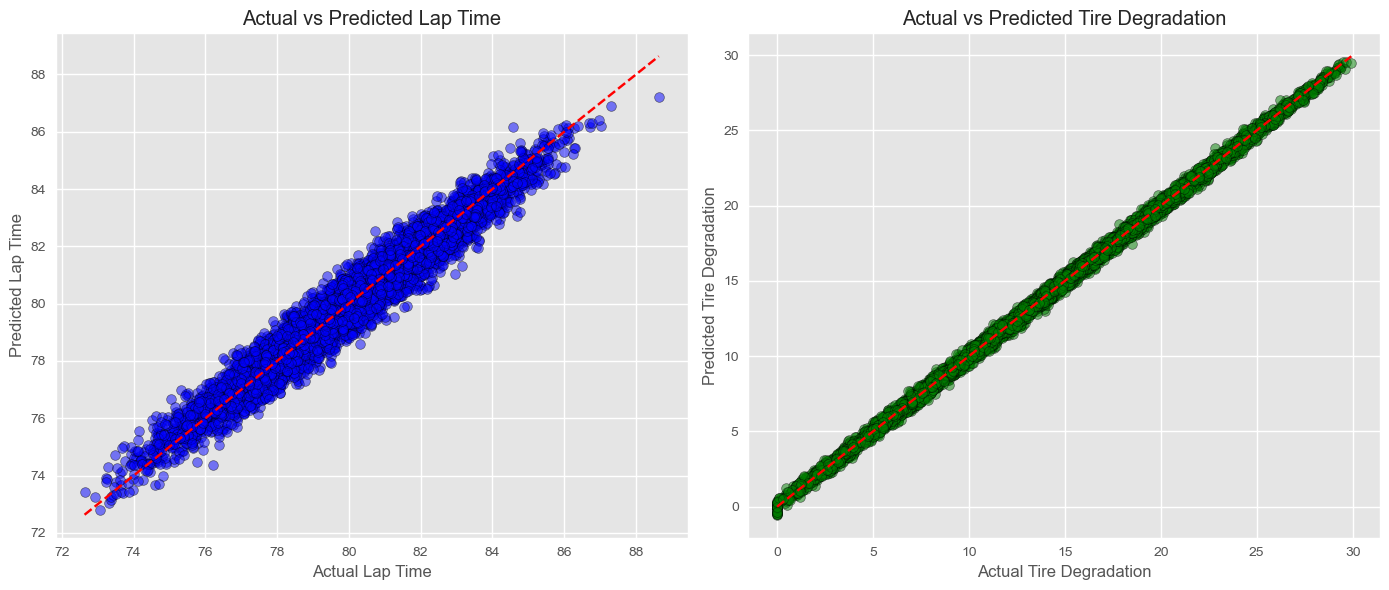

In [45]:
# Plot Actual vs Predicted for Lap Time
plt.figure(figsize=(14, 6))

# Plot Lap Time
plt.subplot(1, 2, 1)
plt.scatter(y_test['lap_time'], y_test_pred[:, 0], alpha=0.5, color='b', edgecolors='k')
plt.plot([y_test['lap_time'].min(), y_test['lap_time'].max()], 
         [y_test['lap_time'].min(), y_test['lap_time'].max()], 'r--')  # Line for perfect predictions
plt.xlabel("Actual Lap Time")
plt.ylabel("Predicted Lap Time")
plt.title("Actual vs Predicted Lap Time")

# Plot Tire Degradation
plt.subplot(1, 2, 2)
plt.scatter(y_test['tyre_degradation'], y_test_pred[:, 1], alpha=0.5, color='g', edgecolors='k')
plt.plot([y_test['tyre_degradation'].min(), y_test['tyre_degradation'].max()], 
         [y_test['tyre_degradation'].min(), y_test['tyre_degradation'].max()], 'r--')  # Line for perfect predictions
plt.xlabel("Actual Tire Degradation")
plt.ylabel("Predicted Tire Degradation")
plt.title("Actual vs Predicted Tire Degradation")

plt.tight_layout()
plt.show()

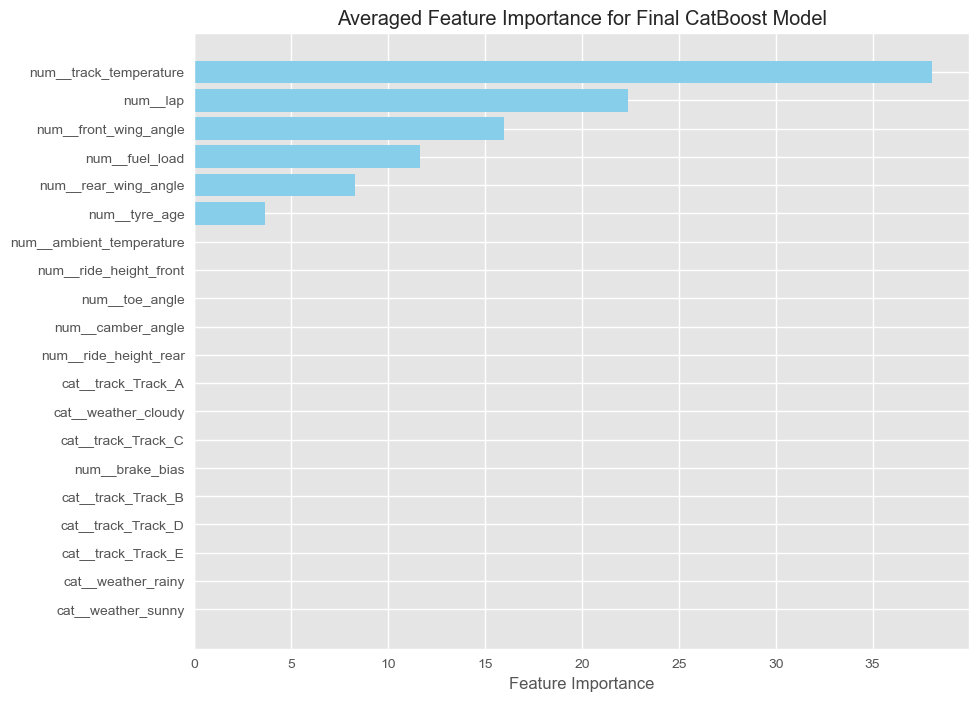

In [74]:
# Access each CatBoost model inside the MultiOutputRegressor
estimators = final_model.named_steps['model'].estimators_

# Ensure the feature names match the shape of feature importances
if hasattr(final_model.named_steps['preprocessor'], 'get_feature_names_out'):
    feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()
else:
    feature_names = X_train.columns

# Extract feature importances from each model and average them
# Ensure each estimator has feature importances matching feature_names
feature_importances = np.mean([estimator.get_feature_importance() for estimator in estimators], axis=0)

# Confirm that feature importances and feature names have the same length
if len(feature_importances) == len(feature_names):
    # Create DataFrame for plotting
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title('Averaged Feature Importance for Final CatBoost Model')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("Feature names and importances have mismatched lengths.")

## Optimal Setup By Track

In [46]:
# Step 9: Optimal Setup Recommendation (Using the best model from each algorithm)
optimal_setups = {}
setup_params = {
    'tyre_age': np.arange(0, 100, 10),
    'front_wing_angle': np.arange(0, 10, 1),
    'rear_wing_angle': np.arange(0, 10, 1),
}
tracks = setup_dataset['track'].unique()
weathers = ['dry', 'wet']
param_combinations = list(product(setup_params['tyre_age'], setup_params['front_wing_angle'], setup_params['rear_wing_angle']))


In [50]:
# Define default values for all other features the model requires
default_values = {
    'ambient_temperature': 20,    # Example default
    'brake_bias': 55,             # Example default
    'camber_angle': -2.5,         # Example default
    'fuel_load': 50,              # Example default
    'lap': 1,                     # Example default
    'ride_height_front': 40,      # Example default
    'ride_height_rear': 60,       # Example default
    'toe_angle': 0.5,             # Example default
    'track_temperature': 30       # Example default
}

In [51]:
# Modify the loop to include all features in setup_df
optimal_setups = {}
for model_name, best_model in best_models.items():
    print(f"\nFinding optimal setups using {model_name} model:")
    for track in tracks:
        for weather in weathers:
            min_combined_score = float('inf')
            best_setup = None
            for params in param_combinations:
                # Include all features in setup_df, using default values for non-optimized features
                setup_df = pd.DataFrame({
                    'track': [track],
                    'weather': [weather],
                    'tyre_age': [params[0]],
                    'front_wing_angle': [params[1]],
                    'rear_wing_angle': [params[2]],
                    # Add default values for other required features
                    **default_values
                })
                
                # Predict and calculate combined score
                lap_time_pred, tyre_deg_pred = final_model.predict(setup_df)[0]
                # The reward function can be customized based on the specific requirements
                combined_score = lap_time_pred + 0.5 * tyre_deg_pred
                if combined_score < min_combined_score:
                    min_combined_score = combined_score
                    best_setup = {
                        'track': track,
                        'weather': weather,
                        'tyre_age': params[0],
                        'front_wing_angle': params[1],
                        'rear_wing_angle': params[2]
                    }
            optimal_setups[(track, weather, model_name)] = best_setup


Finding optimal setups using Gradient Boosting model:

Finding optimal setups using CatBoost model:


In [53]:
# The optimal setups suggest the values that the there is an issue with the data which is the case.
pd.DataFrame(optimal_setups).T

track weather tyre_age front_wing_angle   
Track_D dry Gradient Boosting  Track_D     dry        0                9  \
        wet Gradient Boosting  Track_D     wet        0                9   
Track_E dry Gradient Boosting  Track_E     dry        0                9   
        wet Gradient Boosting  Track_E     wet        0                9   
Track_C dry Gradient Boosting  Track_C     dry        0                9   
        wet Gradient Boosting  Track_C     wet        0                9   
Track_B dry Gradient Boosting  Track_B     dry        0                9   
        wet Gradient Boosting  Track_B     wet        0                9   
Track_A dry Gradient Boosting  Track_A     dry        0                9   
        wet Gradient Boosting  Track_A     wet        0                9   
Track_D dry CatBoost           Track_D     dry        0                9   
        wet CatBoost           Track_D     wet        0                9   
Track_E dry CatBoost           Track_E     dry        0                9   
        wet CatBoost           Track_E     wet        0                9   
Track_C dry CatBoost           Track_C     dry        0                9   
        wet CatBoost           Track_C     wet        0                9   
Track_B dry CatBoost           Track_B     dry        0                9   
        wet CatBoost           Track_B     wet        0                9   
Track_A dry CatBoost           Track_A     dry        0                9   
        wet CatBoost           Track_A     wet        0                9   

                              rear_wing_angle  
Track_D dry Gradient Boosting               9  
        wet Gradient Boosting               9  
Track_E dry Gradient Boosting               9  
        wet Gradient Boosting               9  
Track_C dry Gradient Boosting               9  
        wet Gradient Boosting               9  
Track_B dry Gradient Boosting               9  
        wet Gradient Boosting               9  
Track_A dry Gradient Boosting               9  
        wet Gradient Boosting               9  
Track_D dry CatBoost                        9  
        wet CatBoost                        9  
Track_E dry CatBoost                        9  
        wet CatBoost                        9  
Track_C dry CatBoost                        9  
        wet CatBoost                        9  
Track_B dry CatBoost                        9  
        wet CatBoost                        9  
Track_A dry CatBoost                        9  
        wet CatBoost                        9

## Implementation Using ML Flow
- How would we productionise the model
- Build a streamlit dashboard

In [62]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

2024/10/28 08:52:38 INFO mlflow.tracking.fluent: Experiment with name 'F1 Model Experiment' does not exist. Creating a new experiment.
/Users/laurencemcdonald/anaconda3/envs/torch/lib/python3.9/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Successfully registered model 'F1_LapTime_Model_v2'.
Created version '1' of model 'F1_LapTime_Model_v2'.
Successfully registered model 'F1_LapTime_Model'.
Created version '1' of model 'F1_LapTime_Model'.


<ModelVersion: aliases=[], creation_timestamp=1730105560855, current_stage='None', description=None, last_updated_timestamp=1730105560855, name='F1_LapTime_Model', run_id='7bbc78082b1546a5bf3d6ece7bb84fc3', run_link=None, source='/Users/laurencemcdonald/anaconda3/envs/torch/lib/python3.9/site-packages/mlflow/types/utils.py:407/150526531570135585/7bbc78082b1546a5bf3d6ece7bb84fc3/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

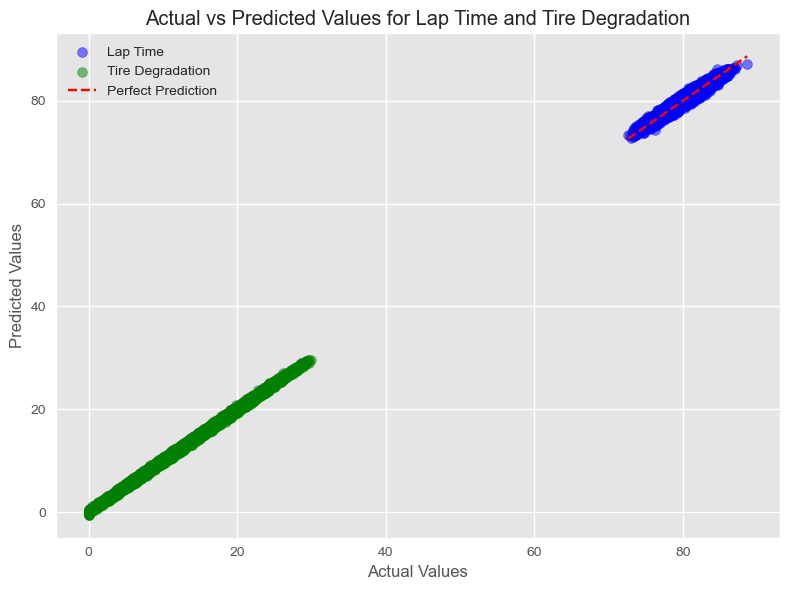

In [68]:
# Ensure final_model is defined correctly from best_models
final_model = best_models['CatBoost']

# Define experiment
mlflow.set_experiment("F1 Model Experiment")

with mlflow.start_run() as run:
    # Log parameters
    mlflow.log_param("model_type", "CatBoost")
    mlflow.log_param("num_estimators", final_model.named_steps['model'].get_params()['estimator__iterations'])
    
    # Log metrics on test data
    y_test_pred = final_model.predict(X_test)
    lap_time_rmse = np.sqrt(mean_squared_error(y_test['lap_time'], y_test_pred[:, 0]))
    tyre_deg_rmse = np.sqrt(mean_squared_error(y_test['tyre_degradation'], y_test_pred[:, 1]))
    
    mlflow.log_metric("Test RMSE Lap Time", lap_time_rmse)
    mlflow.log_metric("Test RMSE Tire Degradation", tyre_deg_rmse)
    
    # Define an input example and infer model signature
    input_example = X_test.iloc[:1]  # Use the first row as an example
    signature = infer_signature(input_example, final_model.predict(input_example))
    
    # Log the model with input example and signature
    mlflow.sklearn.log_model(final_model, "model", input_example=input_example, signature=signature)

    # Capture the run ID to use later
    run_id = run.info.run_id
    model_uri = f"runs:/{run.info.run_id}/model"
    mlflow.register_model(model_uri, "F1_LapTime_Model_v2")
    
    # Plot and log an artifact for Actual vs Predicted Lap Time
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test['lap_time'], y_test_pred[:, 0], alpha=0.5, label="Lap Time", color="blue")
    plt.scatter(y_test['tyre_degradation'], y_test_pred[:, 1], alpha=0.5, label="Tire Degradation", color="green")
    plt.plot([y_test['lap_time'].min(), y_test['lap_time'].max()],
             [y_test['lap_time'].min(), y_test['lap_time'].max()], 'r--', label="Perfect Prediction")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted Values for Lap Time and Tire Degradation")
    plt.legend()
    plt.tight_layout()
    plt.savefig("lap_time_vs_pred_plot.png")
    mlflow.log_artifact("lap_time_vs_pred_plot.png")

# Register the model after the run has ended
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri, "F1_LapTime_Model")

Example Monitoring for new batches of data:

In [69]:
def log_and_monitor(model, new_data, new_targets):
    y_pred = model.predict(new_data)
    rmse = np.sqrt(mean_squared_error(new_targets, y_pred))

    with mlflow.start_run(run_name="monitoring", nested=True):
        mlflow.log_metric("RMSE", rmse)
        # Additional drift detection can go here

    print(f"Logged RMSE for new data batch: {rmse}")